# Gradient-Free-Optimizers: A Quick Introduction

Find the needle in the haystack - without gradients.

**Welcome!** This notebook will teach you the fundamentals of gradient-free optimization in about 10 minutes. By the end, you'll understand when and how to use these algorithms for hyperparameter tuning, engineering design, and any problem where gradients aren't available.

Let's start by setting up our environment with consistent styling for the visualizations.

In [1]:
# Setup: reproducibility and styling
import matplotlib.pyplot as plt
import numpy as np

SEED = 42
np.random.seed(SEED)

plt.rcParams.update(
    {
        "figure.figsize": (10, 6),
        "figure.dpi": 100,
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

COLORS = {
    "primary": "#2E86AB",
    "secondary": "#A23B72",
    "accent": "#F18F01",
    "highlight": "#C73E1D",
}

## 1. The Challenge: Finding the Optimum

Imagine you're blindfolded on a bumpy landscape. Your goal: find the highest point.

This is optimization - and when you can't compute gradients (the slope), you need gradient-free methods.

In [ ]:
# The Rastrigin function: a challenging landscape with many local optima
def rastrigin_2d(x, y):
    """Compute the negated Rastrigin function for 2D visualization."""
    A = 10
    return -(
        A * 2 + (x**2 - A * np.cos(2 * np.pi * x)) + (y**2 - A * np.cos(2 * np.pi * y))
    )


# Visualize the landscape
x = np.linspace(-5.12, 5.12, 200)
y = np.linspace(-5.12, 5.12, 200)
X, Y = np.meshgrid(x, y)
Z = rastrigin_2d(X, Y)

fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(X, Y, Z, levels=50, cmap="viridis")
ax.scatter(
    [0],
    [0],
    color=COLORS["highlight"],
    s=200,
    marker="*",
    label="Global optimum (0, 0)",
    zorder=5,
    edgecolors="white",
    linewidth=2,
)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Can you find the maximum? (Hint: there are many traps!)")
ax.legend(loc="upper right")
plt.colorbar(contour, label="Score")
plt.tight_layout()
plt.show()

**What you're seeing:** This is the *Rastrigin function*, a classic optimization benchmark. The bright yellow regions are the peaks (high scores), and the dark purple valleys are the traps (local optima). Notice how the landscape is covered with a regular pattern of hills - there's only ONE global maximum at the center (0, 0), but dozens of tempting local maxima that could fool a naive optimizer.

This is exactly the kind of problem where gradient-free methods shine: the surface is too bumpy for gradient descent, and the many local optima make simple hill climbing unreliable.

> **The Problem**: Many real-world optimization problems (hyperparameter tuning, engineering design, neural architecture search) don't have computable gradients. That's where Gradient-Free-Optimizers shines.

## 2. The Pattern: Three Simple Steps

Using Gradient-Free-Optimizers follows a consistent pattern:

1. **Define the search space** - where should we look?
2. **Define the objective function** - what are we optimizing?
3. **Run the optimizer** - let the algorithm find the best solution

In [ ]:
from gradient_free_optimizers import HillClimbingOptimizer

# Step 1: Define WHERE to search (using numpy arrays)
search_space = {
    "x1": np.arange(-5, 5, 0.1),
    "x2": np.arange(-5, 5, 0.1),
}


# Step 2: Define WHAT to optimize (return a score to MAXIMIZE)
def objective_function(params):
    """Compute negative parabola with maximum at origin."""
    x1, x2 = params["x1"], params["x2"]
    # Negative parabola: maximum at (0, 0)
    return -(x1**2 + x2**2)


# Step 3: Run the optimizer
opt = HillClimbingOptimizer(search_space, random_state=SEED)
opt.search(objective_function, n_iter=100, verbosity=[])

print(f"Best score: {opt.best_score:.4f}")
print(f"Best parameters: x1={opt.best_para['x1']:.2f}, x2={opt.best_para['x2']:.2f}")

**What just happened?** In just 100 iterations, Hill Climbing found parameters very close to the true optimum at (0, 0). The score of -0.01 means we're only 0.01 units away from the perfect score of 0.

Notice how the search space uses **discrete numpy arrays** - the optimizer navigates by selecting indices into these arrays. This discretization is what makes GFO different from continuous optimizers: it's designed for problems where parameters come from a finite set of choices (like hyperparameters in machine learning).

> **Key Insight**: The optimizer always **maximizes** the score. To minimize something, just return the negative value.

## 3. Visualizing the Search

Every optimizer explores the search space differently. Let's watch how Hill Climbing navigates our landscape:

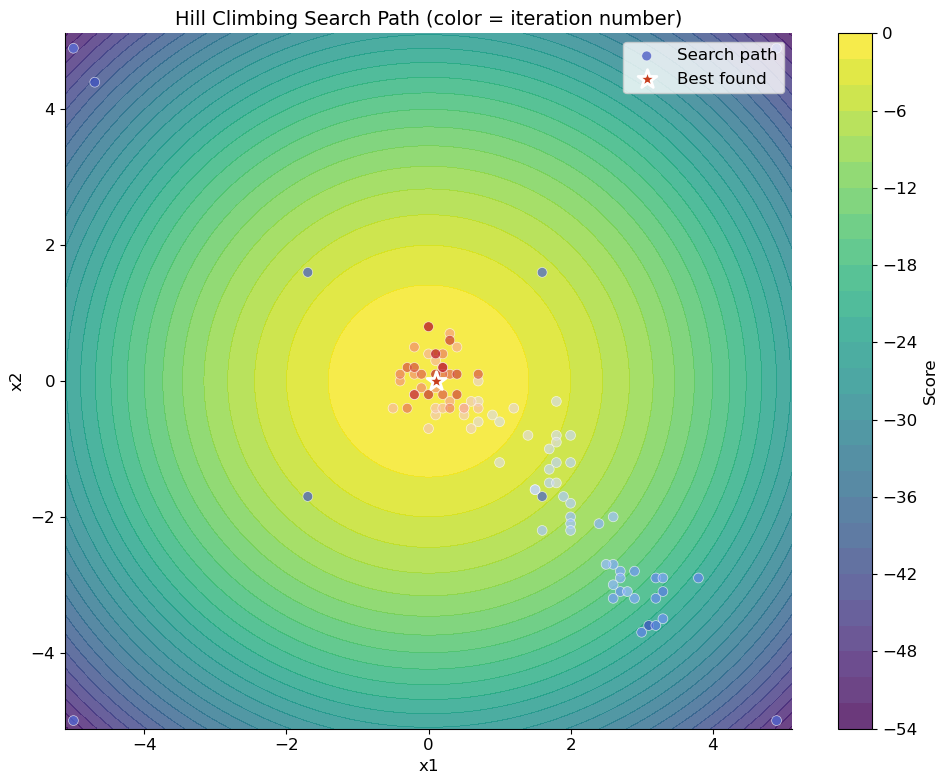

In [4]:
# Run optimization and collect the search history
opt = HillClimbingOptimizer(search_space, random_state=SEED)
opt.search(objective_function, n_iter=100, verbosity=[])

# Get the search data (all evaluated positions)
search_data = opt.search_data

# Visualize the optimization path
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the objective landscape
Z_obj = -(X**2 + Y**2)
contour = ax.contourf(X, Y, Z_obj, levels=30, cmap="viridis", alpha=0.8)

# Plot all evaluated points
ax.scatter(
    search_data["x1"],
    search_data["x2"],
    c=range(len(search_data)),
    cmap="coolwarm",
    s=50,
    alpha=0.7,
    edgecolors="white",
    linewidth=0.5,
    label="Search path",
)

# Mark the best found position
ax.scatter(
    [opt.best_para["x1"]],
    [opt.best_para["x2"]],
    color=COLORS["highlight"],
    s=200,
    marker="*",
    label="Best found",
    zorder=5,
    edgecolors="white",
    linewidth=2,
)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Hill Climbing Search Path (color = iteration number)")
ax.legend(loc="upper right")
plt.colorbar(contour, label="Score")
plt.tight_layout()
plt.show()

**Reading the search path:** The color gradient from blue to red shows the progression of the search over time. Early iterations (blue/purple) start scattered, then the optimizer "homes in" on the optimum as iterations progress (orange/red).

This is the hallmark of **exploitation** - once Hill Climbing finds a promising region, it focuses its search there. The white star marks where the optimizer ended up. You can see how the algorithm took small steps, evaluating neighbors and moving toward better scores.

The `search_data` DataFrame contains the complete history of all evaluated positions - invaluable for understanding optimizer behavior and for warm-starting future runs.

## 4. Choosing Your Optimizer

Different problems call for different strategies. Here's a quick comparison on a harder problem - the Rastrigin function with many local optima:

In [ ]:
from gradient_free_optimizers import (
    HillClimbingOptimizer,
    ParticleSwarmOptimizer,
    RandomSearchOptimizer,
    SimulatedAnnealingOptimizer,
)


# A harder problem: the Rastrigin function with many local optima
def rastrigin_objective(params):
    """Compute the negated Rastrigin function for optimization."""
    x1, x2 = params["x1"], params["x2"]
    A = 10
    return -(
        A * 2
        + (x1**2 - A * np.cos(2 * np.pi * x1))
        + (x2**2 - A * np.cos(2 * np.pi * x2))
    )


optimizers = {
    "Hill Climbing": HillClimbingOptimizer,
    "Random Search": RandomSearchOptimizer,
    "Simulated Annealing": SimulatedAnnealingOptimizer,
    "Particle Swarm": ParticleSwarmOptimizer,
}

results = {}
for name, OptimizerClass in optimizers.items():
    opt = OptimizerClass(search_space, random_state=SEED)
    opt.search(rastrigin_objective, n_iter=200, verbosity=[])
    results[name] = {
        "score": opt.best_score,
        "para": opt.best_para,
        "data": opt.search_data,
    }
    x1, x2 = opt.best_para["x1"], opt.best_para["x2"]
    print(f"{name:20s} | Best: {opt.best_score:8.4f} | Pos: ({x1:5.2f}, {x2:5.2f})")

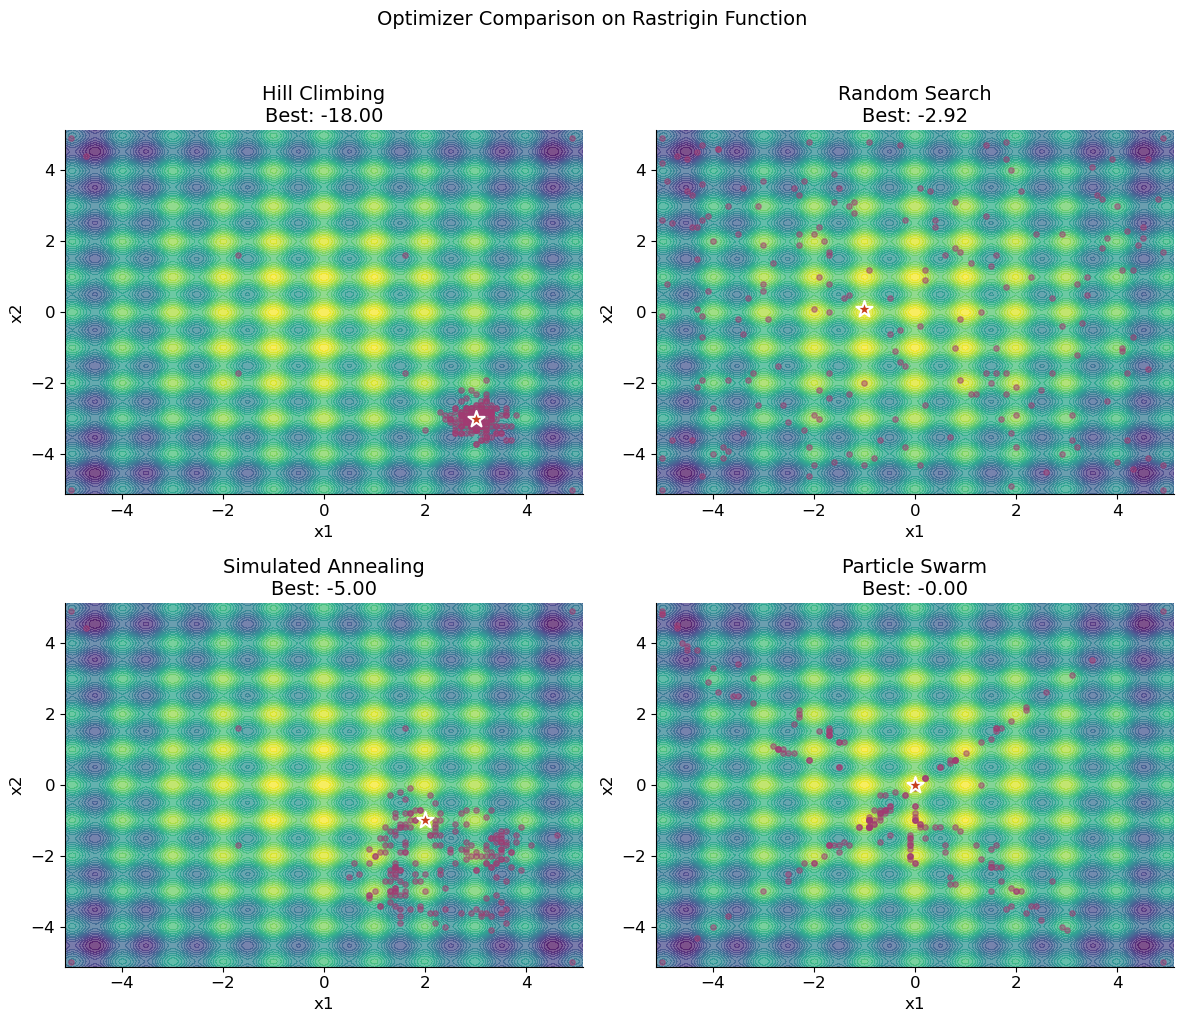

In [6]:
# Visualize how each optimizer explored the space
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    data = result["data"]

    # Plot landscape
    ax.contourf(X, Y, Z, levels=30, cmap="viridis", alpha=0.7)

    # Plot search points
    ax.scatter(
        data["x1"],
        data["x2"],
        c=COLORS["secondary"],
        s=15,
        alpha=0.5,
        label="Evaluated",
    )

    # Mark best position
    ax.scatter(
        [result["para"]["x1"]],
        [result["para"]["x2"]],
        color=COLORS["highlight"],
        s=150,
        marker="*",
        zorder=5,
        edgecolors="white",
        linewidth=1.5,
    )

    ax.set_title(f"{name}\nBest: {result['score']:.2f}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

plt.suptitle("Optimizer Comparison on Rastrigin Function", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Comparing the results:**

- **Hill Climbing** got trapped in a local optimum (score: -18.0). It found a nice-looking hill and stayed there, never escaping to explore further.
- **Random Search** did better by pure chance - it sampled broadly and happened to find a decent spot.
- **Simulated Annealing** uses a "cooling" strategy that allows occasional bad moves early on, helping it escape traps - but 200 iterations wasn't quite enough here.
- **Particle Swarm** found the global optimum (score: 0.0)! Its population of "particles" share information about good regions, enabling collaborative exploration.

Look at the scatter patterns: Hill Climbing's points cluster tightly (exploitation), while Particle Swarm spreads across the space (exploration). This exploration-exploitation trade-off is fundamental to optimization.

## 5. Quick Reference

Gradient-Free-Optimizers provides 20+ algorithms across four categories:

| Category | Algorithms | Best For |
|----------|------------|----------|
| **Local** | Hill Climbing, Simulated Annealing, Downhill Simplex | Fine-tuning near a good solution |
| **Global** | Random Search, Grid Search, Pattern Search | Exploring large spaces |
| **Population** | Particle Swarm, Genetic Algorithm, Evolution Strategy | Complex landscapes |
| **Model-based** | Bayesian Optimization, TPE, Forest Optimizer | Expensive objective functions |

> **Pro Tip**: For expensive objective functions (ML training, simulations), use **Bayesian Optimization** - it learns from past evaluations to make smarter choices.

## Next Steps

You've learned the core pattern. Here's what to explore next:

- **Constraints**: Limit the search space with custom rules
- **Memory**: Warm-start optimizers with previous results  
- **Callbacks**: Monitor and control optimization in real-time

Check out the [documentation](https://simonblanke.github.io/gradient-free-optimizers-documentation) for more!

In [7]:
# What's available?
import gradient_free_optimizers as gfo

print("Available optimizers:")
for name in sorted(gfo.__all__):
    print(f"  - {name}")

Available optimizers:
  - BayesianOptimizer
  - DifferentialEvolutionOptimizer
  - DirectAlgorithm
  - DownhillSimplexOptimizer
  - EnsembleOptimizer
  - EvolutionStrategyOptimizer
  - ForestOptimizer
  - GeneticAlgorithmOptimizer
  - GridSearchOptimizer
  - HillClimbingOptimizer
  - LipschitzOptimizer
  - ParallelTemperingOptimizer
  - ParticleSwarmOptimizer
  - PatternSearch
  - PowellsMethod
  - RandomAnnealingOptimizer
  - RandomRestartHillClimbingOptimizer
  - RandomSearchOptimizer
  - RepulsingHillClimbingOptimizer
  - SimulatedAnnealingOptimizer
  - SpiralOptimization
  - StochasticHillClimbingOptimizer
  - TreeStructuredParzenEstimators
